# Week 3 Lab: Population genetics (How tall should I be?)


## Part 2 (40 pts)

Skills covered: GWAS, plink, p-values, plotting

Height is a great example of a *complex trait*: On one hand, we know height has some genetic component. For example, height is about 80% correlated between identical twins. On the other hand, height is influenced by many other factors, like diet for example.

There is no single gene that controls height. Rather, literally thousands of SNPs and other types of variants in our genome work together to help determine how tall any individual person will be.

We would like to determine which positions in the genome are responsible for height. We have collected a cohort of people with diverse backgrounds (the same set of people from Part 1 of the lab) and have also measured their height. The goal of today's lab is to perform a GWAS on these samples to find specific SNPs that are correlated with height. We'll also explore the effects of confounding factors including sex and ancestry on our analysis.

**<font color="red">Note</a>**: This notebook may take a long time to validate. Validation is not necessary since this notebook will not be autograded. 

**<font color="red">Note</a>**: In parts of this lab we'll be using the Python pandas library, which is very useful for analyzing anything where you have tables of data. We'll talk more about this in class and lab.


## 1. Meet plink, the swiss army knife for population genetics

For our GWAS and related analyses, we'll primarily be using the [plink](https://www.cog-genomics.org/plink/1.9) package, which is a general toolkit for doing all kinds of operations on genetic datasets.

Plink can do dozens of different things, which is great but can be a little overwhelming. We won't be using most options available in plink so will walk through the specific flags in most cases. 

Before diving in, let's get familiar with the plink (yet another) file format(s). In part 1, our genotypes were in VCF format. Plink mostly uses its own format to store genotypes, which is just another way to store the kind of info available in VCF files. As a reminder, data files for this lab can be found in `/datasets/cs185-sp21-A00-public/week3/`.

Almost every plink command takes `--file` as an argument, which gives a prefix to the following files:
* `$PREFIX.ped`: This file contains all the genotype information. There is one row per individual. The columns are described [here](https://www.cog-genomics.org/plink2/formats#ped). There are 2V+6 fields, where V is the number of variants. The first 6 columns contain: family id, sample id, id of father (if known), id of mother (if known), sex code, and phenotype value. Each column after that gives the genotype for each variant in each sample. There are two columns giving the two alleles of each sample.
* `$PREFIX.map`: This file describes the variants whose genotypes are given in the .ped file. It has four columns: chromosome, SNP ID, position in centimorgans (or 0 if ignored), and genomic position.
* `$PREFIX.fam`: Same as the first 6 columns of the .ped file.

We will have one additional file with phenotype information, which could have alternatively been stored in the .ped file:
* `$PREFIX.phen`: This file has 3 columns: family id, sample id, and phenotype. 

Here our samples aren't related, so we don't need to worry about family IDs. We have just set those to be the same as the sample IDs.

Since it takes a while, we have already gone ahead and converted the genotypes from our cohort to plink format. We used the command below to make plink files in the `week3` directory (**don't run this though!**)

```shell
# Don't run this! Just shown FYI
plink --snps-only --vcf gtdata_1000Genomes.vcf.gz --recode --out gtdata_1000Genomes
```

This produced `gtdata_1000Genomes.ped` and `gtdata_1000Genomes.map`. We also have added a `gtdata_1000Genomes.fam` which includes the sex of each sample, as well as `gtdata_1000Genomes.phen` which includes the phenotype. Here the phenotype (height) is a quantitative value (which may be negative, since it has been normalized to have mean 0 and variance 1).

`plink` is very helpful for performing many different operations on genetics datasets, including subsetting samples or variants, computing quality control metrics, and performing association tests. To get started, we will first create a new dataset consisting only of European samples. While we could analyze all samples together, as we'll see below the more homogeneous our data is the better power our GWAS will have in general. We will discuss in class strategies for, and the importance of, performing GWAS in more diverse population groups.

**Question 1 (3 pts)**: First create a file at `~/week3/eur_samples.keep` containing the family and sample ids (first two columns of the FAM file) for all samples with ancestries CEU, FIN, GBR, or TSI (these are all European sub populations). Recall you can look up population codes in the file `gtdata_sample_labels.csv` [here](http://www.internationalgenome.org/category/population/). You should be able to do this using UNIX commands. Paste your command(s) below. How many European samples are in your list?

Hints (there are many ways to do this):
* You could first create a file with European sample IDs by grepping for the corresponding European population groups.
* You can then search the `.fam` file for matches to those samples and output only the first two columns (family and sample id).
* `grep -f<file.txt>` searches for lines matching any pattern given in `file.txt`

cat gtdata_sample_labels.csv | grep CEU > keep_samples.txt
cat gtdata_sample_labels.csv | grep FIN >> keep_samples.txt
cat gtdata_sample_labels.csv | grep GBR >> keep_samples.txt
cat gtdata_sample_labels.csv | grep TSI >> keep_samples.txt
cut -d "," -f 1 keep_samples.txt > keep_ids.txt
cut -f 1-2 gtdata_1000Genomes.fam | grep -f keep_ids.txt > eur_samples.keep

**Question 2 (1 pt)**: Now, let's use `plink` to extract data for only these samples. See the [plink page on input filtering](https://www.cog-genomics.org/plink/1.9/filter) to see how to filter a set of samples (hint, using the file we made above) by **modifying** the command below. Paste the command you used in the cell below.

```shell
plink --file /datasets/cs185-sp21-A00-public/week3/gtdata_1000Genomes --make-bed --out ~/week3/gtdata_EUR
```

<font color="red">Note, this can take a while to run. If it is taking too long, we have precomputed the results for you here: `/datasets/cs185-sp21-A00-public/week3/precomputed/gtdata_EUR*`. You can copy those to your `~/week3` directory if your command is taking too long. But you still need to paste the command you tried to use below!</font>

plink --file /datasets/cs185-sp21-A00-public/week3/gtdata_1000Genomes --make-bed --keep eur_samples.keep --out ~/week3/gtdata_EUR

Note, by including options `--make-bed --out ~/week3/gtdata_EUR`, we are telling `plink` to output files to prefix `~/week3/gtdata_EUR` and to make *binary* files rather than plain text files. Plink binary files consist of a `.bim` and `.bed` file, which contain the same info as the `.ped` and `.map` files (similar to SAM vs. BAM files). (Unfortunately there's not an easy way we know of to look at these binary files similar to `samtools view` for BAM.)

For `plink` commands using the binary format, you'll use `--bfile <prefix>` rather than `--file <prefix>` to specify the input files.

By the way, these bed files are *different than the BED format we saw on in Part 1* despite having the same name (confusing, I know. sorry we didn't make this up...).

## 2. Preprocessing the phenotype data

Before running your GWAS, it is a good idea to take a look at the phenotype data. The file `gtdata_1000Genomes.phen` in the `week3` directory contains the adjusted height values for each of our samples. Look at the head of the file to see the columns (family ID, sample ID, and phenotype):

```
head /datasets/cs185-sp21-A00-public/week3/gtdata_1000Genomes.phen
```

**Question 3 (1 pt):** Make a new phenotype file at `~/week3/gtdata_EUR.phen` with the phenotype data *only* for the same set of European samples. Paste any command(s) you used to do this below.

cat /datasets/cs185-sp21-A00-public/week3/gtdata_1000Genomes.phen | grep -f keep_ids.txt > ~/week3/gtdata_EUR.phen

Now, let's plot a histogram of the data to see how it's distributed. Recall from previous labs, that you should first copy any files that your notebook loads directly (e.g. `gtdata_EUR.phen`) to the same directory as this notebook.

Populating the interactive namespace from numpy and matplotlib


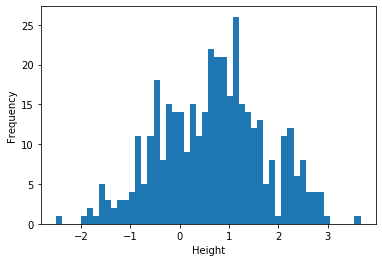

In [2]:
%pylab inline

import pandas as pd
import os

# Load phenotyope data
pt = pd.read_csv("gtdata_EUR.phen",
                delim_whitespace=True, names=["FID","sample","phen"])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(pt["phen"], bins=50)
ax.set_xlabel("Height")
ax.set_ylabel("Frequency");

This should look kind of like a bell shaped curve (although a choppy one).

However we should still think about potential confounding factors before proceeding. One major factor affecting height is sex: males are typically several inches taller than females. This is for the most part not directly related to genetics, but rather is due to biological differences between sexes.

Let's visualize the height distribution separately for males and females.

Luckily we have recorded sex information in the fam file. The code below merges the fam file information with our phenotypes dataframe:

In [3]:
# Load the fam file into a pandas data frame
fam = pd.read_csv("/datasets/cs185-sp21-A00-public/week3/gtdata_1000Genomes.fam",
                 delim_whitespace=True, names=["FID","sample","MID","PID","Sex","x"])
# Merge the pt and fam data frame
data = pd.merge(fam[["sample","Sex"]], pt, on=["sample"])
# Peek at the head of the file to make sure it merged correctly.
data.head()

,sample,Sex,FID,phen
0,NA06984,1,NA06984,2.393471
1,NA06989,2,NA06989,0.749486
2,NA12347,1,NA12347,2.715316
3,NA12348,2,NA12348,1.188012
4,NA06986,1,NA06986,2.197843


You can use `pandas` to easily take subsets of your data based on different columns. For example, to extract only the male samples:

In [4]:
males = data[data["Sex"]==1]
males.head()

,sample,Sex,FID,phen
0,NA06984,1,NA06984,2.393471
2,NA12347,1,NA12347,2.715316
4,NA06986,1,NA06986,2.197843
6,NA07051,1,NA07051,2.281699
7,NA12340,1,NA12340,2.826855


**Question 4 (3 pts)**: Create a new histogram that plots male and female heights separately on the same plot using different colors for each. (Note, you can add `alpha=0.5` to your `hist` command to make the histograms transparent, which will allow you to see both histograms at once even if parts of them overlap).

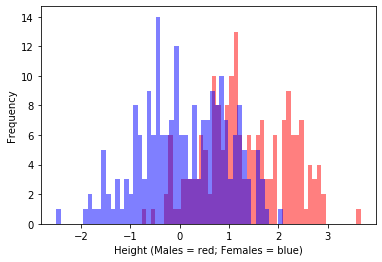

In [9]:
# YOUR CODE HERE
females = data[data["Sex"]==2]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(males["phen"], bins=50, color="red", alpha=0.5)
ax.hist(females["phen"], bins=50, color="blue", alpha=0.5)
ax.set_xlabel("Height (Males = red; Females = blue)")
ax.set_ylabel("Frequency");

You should have found that the male curve is shifted quite a bit to the right. Since we are only interested in finding genetic factors not related to sex in our analysis, let's first mean-center the male and female data separately to put them on the same scale.

The code below (1) scales the male and female data to have mean 0, (2) generates a new histogram plotting the two separately like you did above, and (3) outputs a modified phenotype file to `~/week3/gtdata_EUR_adj.phen` with the adjusted phenotypes we will use in our GWAS analysis.

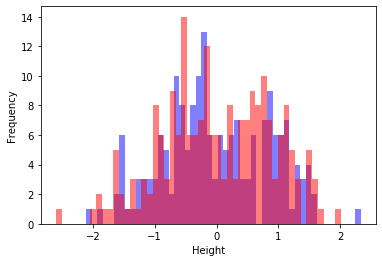

In [10]:
mean_male = np.mean(data[data["Sex"]==1]["phen"])
mean_female = np.mean(data[data["Sex"]==2]["phen"])

data["phen.centered"] = 0 # Replace with mean-centered phenotypes, scaled separately for males and females

# Below, adjust phenotypes for males and females and set to column data["phen.centered"]
# This gets applied to each row of the data frame
# x[col] accesses the value of col for that row
def CenterPhenotype(x, mean_female, mean_male):
    if x["Sex"]==1: return x["phen"]-mean_male
    elif x["Sex"]==2: return x["phen"]-mean_female
    else: return None
    
# df.apply(lambda x: f(x, ..._, 1) applies a function separately to each row of the dataframe
data["phen.centered"] = data.apply(lambda x: CenterPhenotype(x, mean_female, mean_male), 1)

# Plot histogram
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(data[data["Sex"]==1]["phen.centered"], bins=50, color="blue", alpha=0.5)
ax.hist(data[data["Sex"]==2]["phen.centered"], bins=50, color="red", alpha=0.5)
ax.set_xlabel("Height")
ax.set_ylabel("Frequency");

# Output phenotype file
data[["FID","sample","phen.centered"]].to_csv(os.path.join(os.environ["HOME"], "week3","gtdata_EUR_adj.phen"), 
                                              sep=" ", index=False, header=False)

## 3. Performing the GWAS!

Now, let's go ahead and perform a GWAS on our data! We can do this using `plink`. We'll use a command of the form:

```
plink --bfile <prefix> --pheno <phenfile> --out <outprefix> --linear --allow-no-sex --maf 0.05
```

where:
* `--bfile` is the prefix to our `.bim` and `.bed` files as described above.
* `--pheno` is hthe path to our phenotype file. Be sure to use the adjusted phenotypes from part 2!.
* `--out` is the prefix to name output files. Use a prefix in your `~/week3` directory.
* `--linear` tells plink to perform linear regression.
* `--allow-no-sex` ignores samples without sex specified (since plink may have overwritten sex labels when subsetting your data. No worries since we already performed our own sex adjustment above).
* `--maf 0.05` will only analyze variants with minor allele frequency at least 5% in our cohort.

**Question 5 (2 pts)**: Run a GWAS by modifying the `plink` command above. Paste your command below.

plink --bfile gtdata_EUR --pheno gtdata_EUR.phen --out ~/week3/gwas --linear --allow-no-sex --maf 0.05

This should generate a file `<outprefix>.assoc.linear`. Copy that file to the current directory of this notebook, since we'll use it for some plots below. Take a look at this file. The format is described here: https://www.cog-genomics.org/plink2/formats#assoc. Below shows how to load this file in `pandas` and filter variants with p-value undefined.

In [12]:
assoc = pd.read_csv("gtdata_EUR.assoc.linear", delim_whitespace=True)
assoc = assoc[~np.isnan(assoc["P"])]
assoc.head()

,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P
0,2,rs113106463,11320,A,ADD,395,0.01369,0.16230,0.8711
1,2,rs13390778,11842,G,ADD,395,0.04266,0.32840,0.7428
2,2,rs10172644,11985,G,ADD,395,0.00193,0.01499,0.9880
3,2,rs10171150,12091,G,ADD,395,0.02125,0.16730,0.8672
4,2,rs72770995,13241,C,ADD,395,0.14450,1.08300,0.2797


Here:
* `CHR` gives the chromosme and `BP` gives the position of each variant.
* `SNP` gives the rsID
* `A1` gives the minor allele
* `TEST` tells us we were doing an "additive test" (just standard linear regression)
* `BETA` gives the effect size (regression coefficient) and `P` gives the p-value.

We'll first want to make some visualizations to get a sense of whether our GWAS is working correctly. 

**Question 6 (6 pts)**: Generate a QQ Plot to visualize the distribution of p-value association statistics compared to the expected uniform distribution (both should be plotted in -log10 scale, as in the exercises notebook). Also plot a diagonal line to easily compare your p-values to the expected null distribution.

Hint: You will probably have to write your own code to do this. Existing Python QQ plot functions don't plot exactly what we want. Your plot should have approximate x-axis limits of 0-7 and y-axis limits of 0-14. 

Text(0, 0.5, 'Observed -log10(P)')

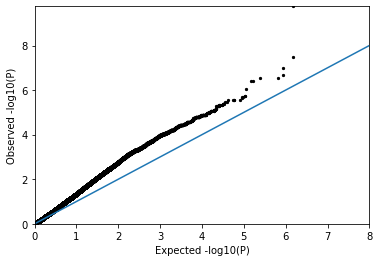

In [32]:
assoc = pd.read_csv("gtdata_EUR.assoc.linear", delim_whitespace=True)
assoc = assoc[~np.isnan(assoc["P"])]
pvals = list(assoc["P"])
pvals.sort()

# YOUR CODE HERE
#raise NotImplementedError()
unif = list(np.random.uniform(0, 1, size=len(pvals)))
unif.sort()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(-1*np.log10(unif), -1*np.log10(pvals), s=5, color="black")
ax.plot([0, 8], [0,8])
ax.set_xlim(left=0, right=8)
ax.set_ylim(bottom=0, top=max(-1*np.log10([item for item in pvals if item >0])))
ax.set_xlabel("Expected -log10(P)")
ax.set_ylabel("Observed -log10(P)")


**Question 7 (2 pts):** Based on your QQ plot, do you think the p-values from our GWAS are reliable? Why or why not?

No, they consistently rise above the y=x line, which indicates that there's some other factor that we haven't controlled for that is affecting phenotype

Let's also make a Manhattan to visualize our data. The cell below does this for you, separately for each chromosome. (You'll have to make your own Manhattan plots below so it's worth looking through this to make sure you understand what it's doing).

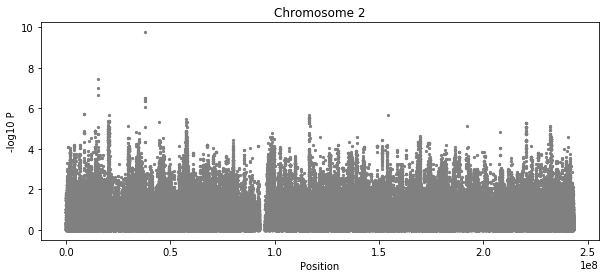

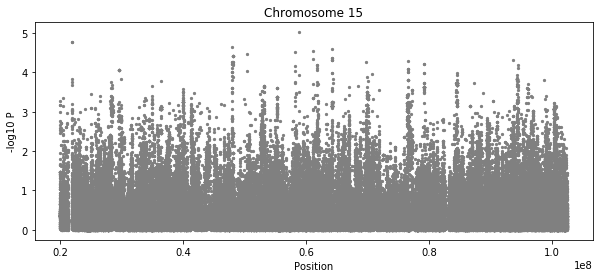

In [33]:
assoc = pd.read_csv("gtdata_EUR.assoc.linear", delim_whitespace=True)
assoc = assoc[~np.isnan(assoc["P"])]

assoc = assoc.sort_values(["CHR","BP"])
color = "gray"
for chrom in set(assoc["CHR"]):
    fig = plt.figure()
    fig.set_size_inches((10, 4))
    ax = fig.add_subplot(111)
    ax.scatter(assoc[assoc["CHR"]==chrom]["BP"], -1*np.log10(assoc[assoc["CHR"]==chrom]["P"]), s=5, color=color)
    ax.set_xlabel("Position")
    ax.set_ylabel("-log10 P");
    ax.set_title("Chromosome %s"%chrom)

**Question 8 (2 pts)**: If your analysis worked, you should see a couple of "skyscrapers" in your plot. Describe what each tower represents.

The towers represent positions where the some gene affects our phenotype

**Question 9 (3 pts)**: Using either Python or the command line, find the top 5 associated SNPs. List their rsids below. Use SNPpedia (https://www.snpedia.com/) to look up what phenotypes the SNPs are associated with. You should find that at least one of them (rs12913832) is the main SNP associated with eye color. Does it make sense that the same SNP for eye color would also be related to height? If not, what is an alternative explanation for why that SNP is significant in our GWAS?

In [64]:
#assoc.head()
sortd = assoc.sort_values(by=["P"])
sortd.head()

,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P
1223281,2,rs199891221,88185205,G,COV1,395,8.896,9.250,1.522000e-18
3144343,15,rs482425,29585752,A,COV1,395,8.971,9.195,2.319000e-18
3143077,15,rs146930247,29487830,G,COV1,395,8.731,9.090,5.179000e-18
3142987,15,rs11634079,29479038,A,COV1,395,8.715,9.065,6.230000e-18
1242895,2,rs2019747,91690040,G,COV1,395,8.845,9.063,6.336000e-18
2401069,2,rs55642839,193323585,C,COV1,395,8.912,9.043,7.390000e-18
2380603,2,rs2043989,191268293,G,COV1,395,9.247,9.038,7.689000e-18
3275701,15,rs201826164,39329147,T,COV1,395,9.005,9.017,8.998000e-18
3855739,15,rs1879529,89414295,T,COV1,395,8.906,9.003,1.000000e-17
2401099,2,rs13428905,193325855,G,COV1,395,8.869,8.996,1.054000e-17


It could be possible if a population that tends to be taller also tends to have a certain eye color (i.e. perhaps people with blue eyes tend to be from northern europe and they tend to be taller)

## 4. Controlling for population structure

You likely found evidence above that our p-values aren't behaving quite like we'd want them to in a reliable GWAS. One likely explanation is that we're clumping together multiple different ancestry groups from Europe into a single analysis. It is well known that Southern Europeans are on average quite a bit shorter than Northern Europeans (https://www.scmp.com/news/world/article/1858274/tall-story-why-northern-europeans-tower-over-their-southern-counterparts). This could be for a variety of reasons, including genetic, diet, or environmental factors.

But Northern vs. Southern Europeans also have thousands of genetic differences that have occurred randomly since the two population groups split, which for the most part have nothing to do with height! Therefore, if we don't control for ancestry, our GWAS is likely to pick up things (like eye color!) that happen to be very different between different European populations but that are not related to the phenotype we're studying.

PCA is a great way to visualize ancestry of our samples. Let's use plink to perform PCA on our cohort (which by the way you could have used to perform PCA in part 1 :) ).

```
plink --bfile ~/week3/gtdata_EUR --out ~/week3/gtdata_EUR --pca 5
```

This should output a file `~/week3/gtdata_EUR.eigenvec` with the value along each principal component for each sample for each of the first 5 principle components. Copy that file over to the current directory of this notebook for plotting.

**Question 10 (5 pts)**: Make a scatter plot of PC1 vs. PC2 for your samples. Color each sample by it's population (not superpopulation like in part 1). Recall the European populations we are using are CEU, GBR, TSI, FIN. Code you wrote for plotting in Monday's lab should be helpful here.

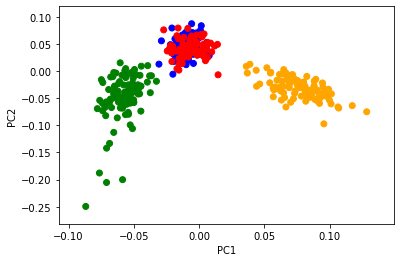

In [54]:
# Load sample data
sample_to_pop = {}
with open("/datasets/cs185-sp21-A00-public/week3/gtdata_sample_labels.csv") as f:
    for line in f:
        s, pop = line.strip().split(",")
        if pop in ["CEU", "GBR", "TSI", "FIN"]:
            sample_to_pop[s] = pop

def GetColor(sample, sample_to_pop):
    if sample_to_pop[sample] == "CEU": return "red" #N/W Eur
    if sample_to_pop[sample] == "GBR": return "blue" #Bri'ish
    if sample_to_pop[sample] == "TSI": return "green" #Italy
    if sample_to_pop[sample] == "FIN": return "orange" #Fin
    return "gray"

pcs = pd.read_csv("gtdata_EUR.eigenvec",
                 delim_whitespace=True, names=["FID","sample","PC1","PC2","PC3","PC4","PC5"])


# YOUR CODE HERE
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pcs["PC1"], pcs["PC2"], color=[GetColor(pop, sample_to_pop) for pop in sample_to_pop])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2");


**Question 11 (2 pts)**: What populations are separated by PC1? PC2? Do these PCs appear to correspond to any particular geographical axes? (e.g. north vs. south, east vs. west?) Which populations appear to be most closely related?

TSI / GBR&CEU / FIN are the three notable separations by PC1&2. British and Americans w/ Northern/Western European background are the most related, probably since the American group came from Britain at some point
Italy and Finland are well separated and they are in the South/North of Europe, respectively

#### We can use PCA (eigenvectors) file directly as input to `plink` to include as covariates in our GWAS analysis. 

Look at the [plink documentation](https://www.cog-genomics.org/plink/1.9/input#covar) to learn how to add covariates to our analysis. You should be able to directly use the file `~/week3/gtdata_EUR.eigenvec` you created above as input to the `--covar` flag. Also you can specify `--linear hide-covar` to only output the variant p-value (by default `plink` also outputs individual tests for each covariate at each SNP).

**Question 12 (4 pts)**: Rerun your GWAS analysis with the top 5 PCs as covariates and removing outlier samples. Regenerate your QQ plot and Manhattan plot using the new results. Paste any commands you use below as comments. If your file loads any plink output for plotting, make sure you first copy it to this directory.

Note: running plink with `--covar` usually takes significantly longer than running it without covariates. Our solution took ~20 minutes to run.

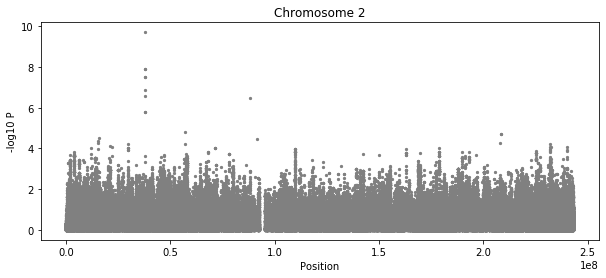

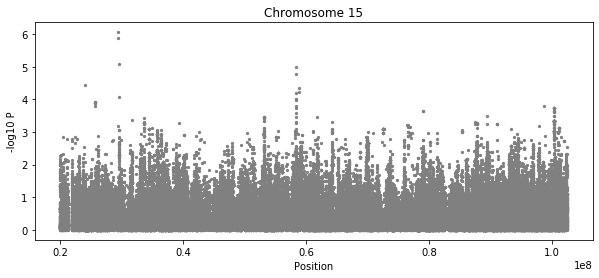

In [68]:
# YOUR CODE HERE
"""
plink --bfile gtdata_EUR --pheno gtdata_EUR.phen --out ~/week3/gwas --linear hide-covar --allow-no-sex --maf 0.05 --covar ~/week3/gtdata_EUR.eigenvec
"""
assoc = pd.read_csv("gwas.assoc.linear", delim_whitespace=True)
assoc = assoc[~np.isnan(assoc["P"])]

assoc = assoc.sort_values(["CHR","BP"])
color = "gray"
for chrom in set(assoc["CHR"]):
    fig = plt.figure()
    fig.set_size_inches((10, 4))
    ax = fig.add_subplot(111)
    ax.scatter(assoc[assoc["CHR"]==chrom]["BP"], -1*np.log10(assoc[assoc["CHR"]==chrom]["P"]), s=5, color=color)
    ax.set_xlabel("Position")
    ax.set_ylabel("-log10 P");
    ax.set_title("Chromosome %s"%chrom)

Text(0, 0.5, 'Observed -log10(P)')

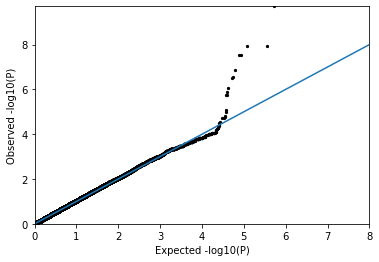

In [69]:
assoc = pd.read_csv("gwas.assoc.linear", delim_whitespace=True)
assoc = assoc[~np.isnan(assoc["P"])]
pvals = list(assoc["P"])
pvals.sort()

# YOUR CODE HERE
#raise NotImplementedError()
unif = list(np.random.uniform(0, 1, size=len(pvals)))
unif.sort()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(-1*np.log10(unif), -1*np.log10(pvals), s=5, color="black")
ax.plot([0, 8], [0,8])
ax.set_xlim(left=0, right=8)
ax.set_ylim(bottom=0, top=max(-1*np.log10([item for item in pvals if item >0])))
ax.set_xlabel("Expected -log10(P)")
ax.set_ylabel("Observed -log10(P)")

**Question 13 (1 pt)**: Based on your updated QQ plot after controlling for covariates, do you think the p-values from our GWAS are reliable? why or why not?

Yes, most SNPs are equal to what we'd expect from randomness except for a few SNPs that are enriched

In [70]:
sortd = assoc.sort_values(by=["P"])
sortd.head()

,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P
90162,2,rs17511102,37960613,T,ADD,395,-0.9951,-6.538,1.964000e-10
90174,2,rs11683151,37963965,G,ADD,395,-0.7438,-5.823,1.216000e-08
90171,2,rs10490279,37963194,T,ADD,395,-0.7438,-5.823,1.216000e-08
90217,2,rs7566658,37987124,G,ADD,395,-0.7236,-5.658,2.986000e-08
90223,2,rs74184888,37988449,T,ADD,395,-0.7236,-5.658,2.986000e-08


**Question 14 (2 pts)**: What happened to the top signal on chromosome 15 you saw before adjusting for ancestry. Is it still there? Why or why not?

I don't see it anymore, it's likely because it was explained by the difference in ancestry (instead of height)

**Question 15 (3 pts)**: Take a look at the top signal (should be on chromosome 2). Search for this region (perhaps by rsid of the top SNP) and try to see if this region has been previously associated with height. Are there any genes nearby (within 100kb) of the top hit? Hypothesize why this locus might be involved in height. (but note, I don't think anyone really knows yet!)

It has been associated with height previously. Just looking at the top 5 SNPS, all of them are close together on chromosome 2. These could be a group of genes that are inherited together frequently (since they are so close), where one of them is the causal gene.